# Making an interannual Map of R
This code should make a map of the variability ratio, 
$$ R \equiv \frac{A_i}{A_f}$$
This ratio is a measure of intrinsic to forced variability.


**In this version, I am also adding a 12-month rolling mean to the eke metric**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33223,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:33583,Total threads: 4
Dashboard: /proxy/36561/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:32933,


In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [4]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EKEDir = 'processed_eke/'
emeanfilename = HardDisk+EKEDir+'SOeke_ensemble_mean.nc'

## Step 1
Compute the ensemble-averaged EKE, $\langle E_i \rangle$, and save in a netcdf file.

In [5]:
nfiles = 50
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    ekefilename = HardDisk+EKEDir+'/eke_'+i00+'_????.nc'
    
    # just take SO, annual running mean:
    eke = xr.open_mfdataset(ekefilename).EKE.sel(lat=slice(None,-30)).load()
    eke = eke.rolling(time=12,center=True).mean()
    #print(ekefilename)
    if nn==1:
        eke_sum = eke
    else:
        eke_sum = eke_sum + eke

eke_sum = eke_sum/nn
eke_sum_clim = eke_sum.groupby('time.month').mean('time')
eke_ensemble_mean = (eke_sum.groupby('time.month') - eke_sum_clim)
eke_ensemble_mean.to_netcdf(emeanfilename)

## Step 2
Calculate the time-variance of the ensemble-mean EKE:
$$\sigma^2_{\langle E \rangle} = \frac{1}{T} \sum_{t=1}^T \left(\langle E_i \rangle -  \overline{\langle E_i \rangle}\right)^2$$
We can bin this into, say 4° boxes, and make a map of this!

**In this version, I am also adding a 12-month rolling mean to the eke metric**

In [6]:
mm=16
eke_ensemble_mean  = xr.open_mfdataset(emeanfilename).EKE
eke_subsampled = eke_ensemble_mean.coarsen({"lon":mm,"lat":mm},boundary='trim').mean().rolling(time=12,center=True).mean().load()
sigma2 = np.var(eke_subsampled,axis=0)

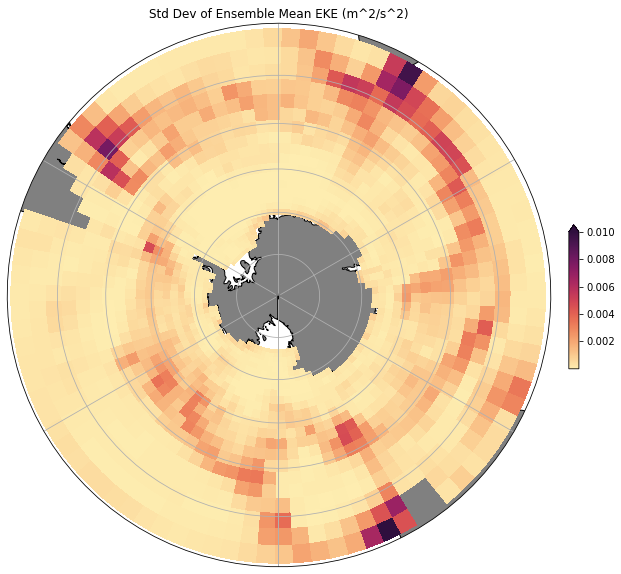

In [7]:
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
sigma=sigma2**0.5
p1=sigma.plot(cmap=cm.cm.matter,vmax=0.01,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('Std Dev of Ensemble Mean EKE (m^2/s^2)')

ax_c = plt.axes([0.8,0.4,0.01,0.2])
plt.colorbar(p1,cax=ax_c,orientation='vertical',extend='max')

**This plot shows the magnitude of forced variability.**

## Step 3
Now we want to read in the EKE for each ensemble member, select just the Southern Ocean region, bin into our 5° boxes, and then take the difference from the ensemble mean for each member:
$$E_i' = E_i - \langle E_i \rangle$$
This allows us to accumulate the ensemble variance,
$$\epsilon^2(t) = \frac{1}{N} \sum_{n=i}^N E_i'(t)^2$$
indicating the spread of each member from the ensemble mean.
Finally, we calculate the time-mean of this ensemble-variance, $\overline{\epsilon^2}$ and make a map of it.


**In this version, I am also adding a 12-month rolling mean to the eke metric**

In [8]:
nfiles=50
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    ekefilename = HardDisk+EKEDir+'/eke_'+i00+'_????.nc'
        
    eke = xr.open_mfdataset(ekefilename).EKE.sel(lat=slice(None,-30))
    eke_bins = eke.coarsen({"lon":mm,"lat":mm},boundary='trim').mean().load()
    eke_bins_clim = eke_bins.groupby('time.month').mean('time')
    eke_bins_deseas = (eke_bins.groupby('time.month') - eke_bins_clim).rolling(time=12,center=True).mean().load()
    #print(ekefilename)
    eke_prime = eke_bins_deseas - eke_subsampled
    if nn==1:
        eke_var = eke_prime**2
    else:
        eke_var = eke_var + eke_prime**2

eke_var = eke_var/nn
epsilon2 = eke_var.mean('time')

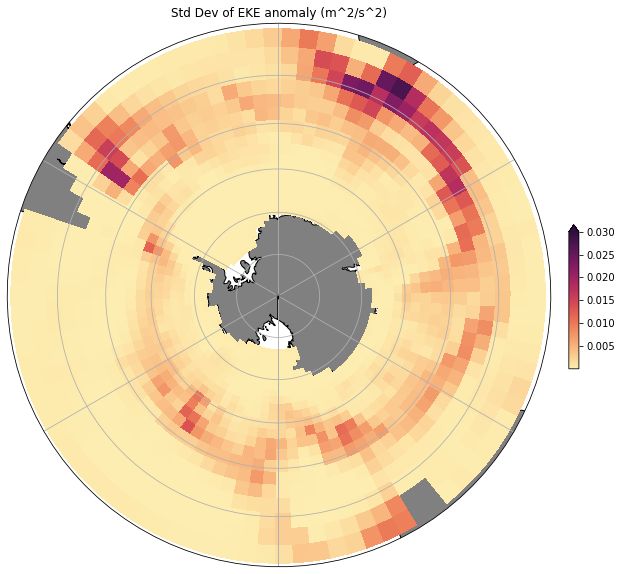

In [9]:
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
epsilon=epsilon2**0.5
p1=epsilon.plot(cmap=cm.cm.matter,vmax=0.03,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('Std Dev of EKE anomaly (m^2/s^2)')

ax_c = plt.axes([0.8,0.4,0.01,0.2])
plt.colorbar(p1,cax=ax_c,orientation='vertical',extend='max')

**This plot shows the magnitude of intrinsic variaibility**

## Step 4
Now calculate the ratio 
$$ R = \frac{A_i}{A_f} = \frac{\sqrt{\overline{\epsilon^2}}}{\sigma_{\langle E \rangle}}$$
for our 5° bins, to give us a map of the intrinsic to forced variance ratio.

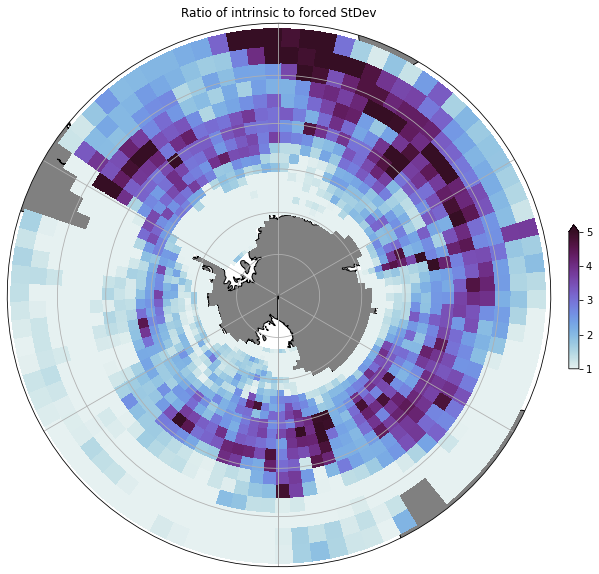

In [10]:
ratio = (epsilon2/sigma2)**0.5

plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
p1=ratio.plot(cmap=cm.cm.dense,vmin=1,vmax=5,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('Ratio of intrinsic to forced StDev')

ax_c = plt.axes([0.8,0.4,0.01,0.2])
plt.colorbar(p1,cax=ax_c,orientation='vertical',extend='max')

**This plot shows that intrinsic variance of EKE within the ACC is quite high.** But there are some patches which are low, including some regions near large topography.

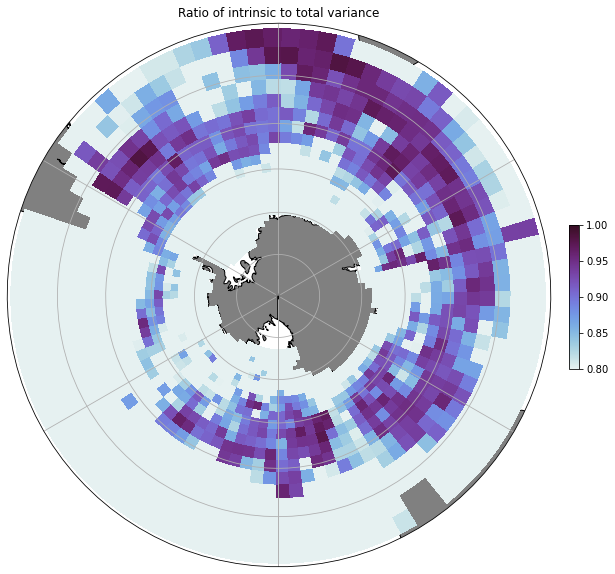

In [11]:
Ri = (epsilon2/(sigma2+epsilon2))
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
p1=Ri.plot(cmap=cm.cm.dense,vmin=0.8,vmax=1.0,add_colorbar=False,transform=ccrs.PlateCarree())
plt.title('Ratio of intrinsic to total variance')

ax_c = plt.axes([0.8,0.4,0.01,0.2])
plt.colorbar(p1,cax=ax_c,orientation='vertical')
#plt.savefig('figures/ForcedRatio.png')

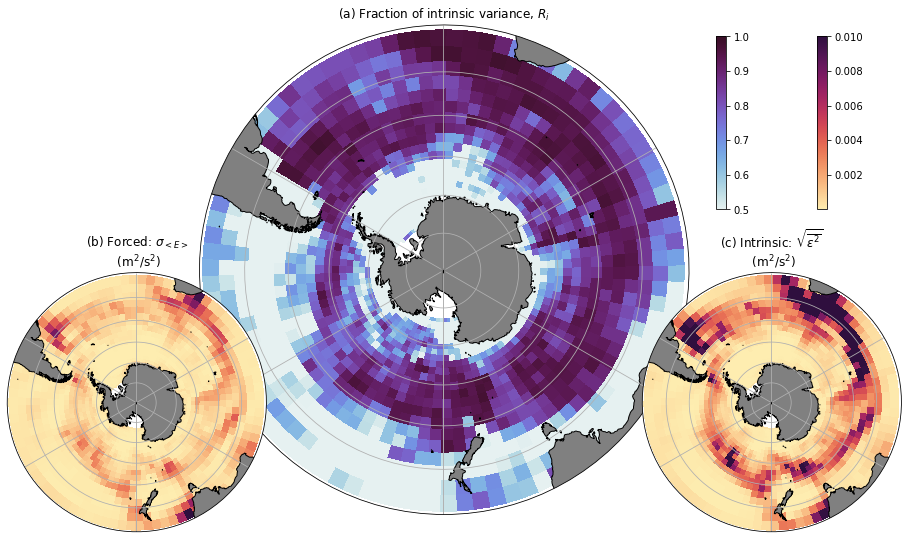

In [19]:
plt.figure(figsize=(14, 8))
ax = plt.axes([0.2, 0.05, 0.6, 0.85],projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.gridlines()
p1=Ri.plot(ax=ax,cmap=cm.cm.dense,vmin=0.5,vmax=1.0,add_colorbar=False,transform=ccrs.PlateCarree())
ax.add_feature(land_50m)
plt.title('(a) Fraction of intrinsic variance, $R_i$')

ax_c = plt.axes([0.77,0.58,0.01,0.3])
plt.colorbar(p1,cax=ax_c,orientation='vertical')

#####
ax2 = plt.axes([0.02, 0.02, 0.35, 0.45],projection=ccrs.SouthPolarStereo())
ax2.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax2.set_boundary(circle, transform=ax2.transAxes)

ax2.gridlines()

p2=sigma.plot(ax=ax2,cmap=cm.cm.matter,vmax=0.01,add_colorbar=False,transform=ccrs.PlateCarree())
ax2.add_feature(land_50m)
plt.title('(b) Forced: $\sigma_{<E>}$\n (m$^2$/s$^2$)')

ax3 = plt.axes([0.65, 0.02, 0.35, 0.45],projection=ccrs.SouthPolarStereo())
ax3.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax3.set_boundary(circle, transform=ax3.transAxes)

ax3.gridlines()
p3=epsilon.plot(ax=ax3,cmap=cm.cm.matter,vmax=0.01,add_colorbar=False,transform=ccrs.PlateCarree())
ax3.add_feature(land_50m)
plt.title('(c) Intrinsic: $\sqrt{\overline{\epsilon^2}}$\n (m$^2$/s$^2$)')


ax_c = plt.axes([0.87,0.58,0.01,0.3])
plt.colorbar(p3,cax=ax_c,orientation='vertical')

plt.savefig('/g/data/x77/amh157/OCCIPUT-analysis/paper/figures/Figure7.png',dpi=200)
#plt.savefig('figures/ForcedRatio.png')